Dataset: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

In [3]:
try:
    red = pd.read_csv('/content/drive/MyDrive/IST347/Project/winequality_red.csv')
except:
    red = pd.read_csv('winequality_red.csv')

In [4]:
try:
    white = pd.read_csv('/content/drive/MyDrive/IST347/Project/winequality_white.csv')
except:
    white = pd.read_csv('winequality_white.csv')

In [5]:
red_col = red.columns.to_list()
white_col = white.columns.to_list()

### Plot Functions

In [6]:
def replace_col():
    '''
    Capitalize column names and remove space to '_', except 'pH' 
    '''
    new_red_col = []
    new_white_col = []
    for r, w in zip(red_col, white_col):

        if r =='pH' or w =='pH':
            new_r = r
            new_w = w
        else:
            new_r = r.title().replace(' ','_')
            new_w = w.title().replace(' ','_')

        new_red_col.append(new_r)
        new_white_col.append(new_w)
    red.columns = new_red_col
    white.columns = new_white_col

# replace column name
replace_col()

In [7]:
def plot_scatter(x_axis,y_axis, h=None):
    '''Plot the scatter plot by input a selected X & Y data'''
    sns.scatterplot(x = x_axis, y = y_axis, hue = h)


In [8]:
def barplot(xlabel,ylabel,rotate,title):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6), dpi=80)
    ax = sns.barplot(x=xlabel, y=ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, horizontalalignment='right')
    ax.set_title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance Level')
    plt.show()

## Data Understanding

In [9]:
red.shape

(1599, 12)

In [10]:
white.shape

(4898, 12)

In [11]:
red.head()

,Fixed_Acidity,Volatile_Acidity,Citric_Acid,Residual_Sugar,Chlorides,Free_Sulfur_Dioxide,Total_Sulfur_Dioxide,Density,pH,Sulphates,Alcohol,Quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [12]:
desc = red.describe() # maybe we should consider scaling since max/min for free_Sulfer_Dioxide and Total_Sulfer_dioxide have a drastic difference

In [13]:
desc

,Fixed_Acidity,Volatile_Acidity,Citric_Acid,Residual_Sugar,Chlorides,Free_Sulfur_Dioxide,Total_Sulfur_Dioxide,Density,pH,Sulphates,Alcohol,Quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [14]:
desc = desc.drop(['25%', '50%', '75%'], axis = 0)

In [15]:
red_desc = pd.DataFrame(desc).transpose()


In [16]:
red_desc

,count,mean,std,min,max
Fixed_Acidity,1599.0,8.319637,1.741096,4.60000,15.90000
Volatile_Acidity,1599.0,0.527821,0.179060,0.12000,1.58000
Citric_Acid,1599.0,0.270976,0.194801,0.00000,1.00000
Residual_Sugar,1599.0,2.538806,1.409928,0.90000,15.50000
Chlorides,1599.0,0.087467,0.047065,0.01200,0.61100
Free_Sulfur_Dioxide,1599.0,15.874922,10.460157,1.00000,72.00000
Total_Sulfur_Dioxide,1599.0,46.467792,32.895324,6.00000,289.00000
Density,1599.0,0.996747,0.001887,0.99007,1.00369
pH,1599.0,3.311113,0.154386,2.74000,4.01000
Sulphates,1599.0,0.658149,0.169507,0.33000,2.00000


In [17]:
red.loc[red.Total_Sulfur_Dioxide>250,'Total_Sulfur_Dioxide'] = red.Total_Sulfur_Dioxide.mean()  #replace outliers with mean
white.loc[(white.Quality ==3) & (white.Total_Sulfur_Dioxide>=300), 'Total_Sulfur_Dioxide'] = white.Total_Sulfur_Dioxide.mean() #replace outliers with mean

Should we consider scaling the df for every algorithm 

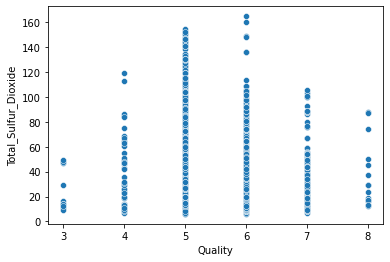

In [18]:
plot_scatter(red.Quality, red.Total_Sulfur_Dioxide)

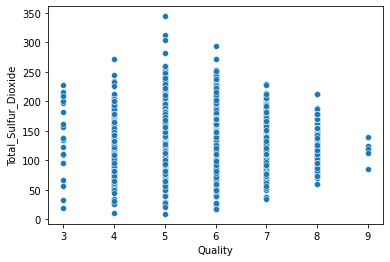

In [19]:
plot_scatter(white.Quality, white.Total_Sulfur_Dioxide)

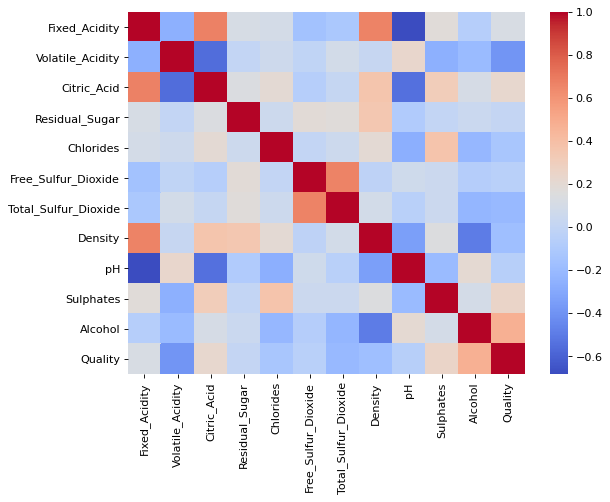

In [20]:
# red wine correlation heatmap
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(red.corr(), cmap='coolwarm')

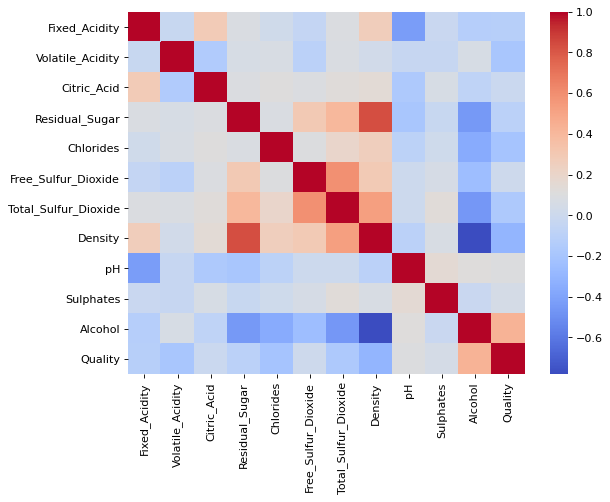

In [21]:
# white wine correlation heatmap
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(white.corr(), cmap='coolwarm')

## Algorithm Functions

### Helper Functions

#### Copy DataFrame

In [22]:
def copy_df(df):
    '''create a copy of a dataframe and replace quality to two groups for logistic regression use'''
    df_copy = df.copy()
    # print(df_copy)
    df_copy.loc[df_copy.Quality <=5, 'Quality'] = 0 #not good
    df_copy.loc[df_copy.Quality >5, 'Quality'] = 1 #good


    return df_copy



#### Colorful Confusion Matrix


In [23]:
def plot_colorful_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

### Regression

In [24]:
def multi_regression(X_train, X_test, y_train, y_test, error = False):

    '''everything for multiregression is here, call the function and it will 
        automatically run and print out everything'''

    from sklearn.linear_model import LinearRegression

    lm = LinearRegression()
    lm.fit(X_train, y_train)
    #print(f'Intercept is {lm.intercept_}')
    #print()
    #print(f'Cntercept is {lm.coef_}')
    #print()

    y_pred = lm.predict(X_test)
    y_pred_1 = []
    for x in y_pred:
        x = round(x)
        y_pred_1.append(x)
    plt.scatter(y_test, y_pred_1)
    plt.show()
    error = print_errors(y_test, y_pred_1)

    importance = lm.coef_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    return importance

In [25]:
def ridge(X_train, X_test, y_train, y_test, alpha=1):
    from sklearn.linear_model import Ridge
    from sklearn import metrics

    error = []
    for x in range(1,50):
        test = []
        test_2 = []
        lm_1 = Ridge(alpha = x)
        lm_1.fit(X_train,y_train)
        y_pred = lm_1.predict(X_test)
        for y in y_pred:
            y = round(y)
            test.append(y)
        r = metrics.mean_absolute_error(y_test,y_pred)
        error.append(r)
    plt.plot(range(1,50), error)
    plt.ylabel('Error')
    plt.xlabel('k value')
    plt.show()
    importance = lm_1.coef_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    alpha_min = error.index(min(error)) + 1
    print(alpha)

    lm_2 = Ridge(alpha = alpha_min)
    lm_2.fit(X_train,y_train)
    y_pred_2 = lm_2.predict(X_test)
    for y in y_pred_2:
            y = round(y)
            test_2.append(y)
    k = metrics.mean_absolute_error(y_test,test_2)
    print_errors(y_test, test_2)

    return importance

In [26]:
def LR(df,X_train, X_test, y_train, y_test):

    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix

    new_df = copy_df(df)

    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    print_confusion_metrics(y_test, y_pred)

    importance = lr.coef_[0]
    for i,v in enumerate(importance):
	    print('Feature: %0d, Score: %.5f' % (i,v))
     
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    return y_pred

In [27]:
def print_errors(y_test, y_pred):

    '''print all errors by calling this function'''

    from sklearn import metrics
    print(f'Mean Absolute error is: {metrics.mean_absolute_error(y_test, y_pred)}')
    print()
    print(f'Mean Squared error is: {metrics.mean_squared_error(y_test, y_pred)}')
    print()
    print(f'Mean Squared root error is: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print()
    print(f'R2 score is : {metrics.r2_score(y_test, y_pred)}')
    print()
    


### Classification

#### KNN

In [28]:
def KNN(X_train, X_test, y_train, y_test):

    '''take input and run KNN'''

    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    
    #scale dataset
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    #find best K 

    best_k = 0
    accuracy = 0
    scores = []

    for k in range(1,100):
        knn_model = KNeighborsClassifier(n_neighbors = k)
        # print(knn_model)
        knn_model.fit(scaled_X_train, y_train)
        y_pred = knn_model.predict(scaled_X_test)
        score = accuracy_score(y_test, y_pred)
        # print(f'the K right now is {k}, and its score is {score}')
        scores.append(score)

        if score > accuracy:
            best_k = k
            accuracy = score

    print(f'the best K is: {best_k}, and its score is {accuracy}')

    #plot the accuracy
    plt.figure(dpi=100)
    plt.plot(range(1,100), scores, label = 'Accuracy Score')
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('k value')
    plt.show()

    #using best_k for KNN

    best_model = KNeighborsClassifier(n_neighbors = best_k)
    best_model.fit(scaled_X_train, y_train)
    y_pred = best_model.predict(scaled_X_test)

    # print()
    # print('-------Confusion Metrics Report-------')
    print(f'Accuracy score of the best k is: {accuracy_score(y_test,y_pred)}')


    plt.scatter(y_test,y_pred)
    plt.title('KNN White Wine Result Comparison')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()


    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='KNN White Wine Confusion matrix') 



#### Naive Bayes

In [29]:
def NB(X_train, X_test, y_train, y_test):
    from sklearn.preprocessing import StandardScaler
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import classification_report, confusion_matrix

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    model = GaussianNB()
    clf = model.fit(scaled_X_train, y_train)
    y_pred = clf.predict(scaled_X_test)
    
    # print_confusion_metrics(y_test, y_pred)

    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='White Wine DT Confusion matrix')
    

#### Decision Tree

In [30]:
def DT(X_train, X_test, y_train, y_test, print_tree=None):

    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.tree import plot_tree
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)


    # find the best max_depth 
    accuracy = []
    for k in range(1,100):
        tree_clf = DecisionTreeClassifier(max_depth = k)

        tree_clf.fit(scaled_X_train,y_train)
        y_pred = tree_clf.predict(scaled_X_test)
        acc = accuracy_score(y_test,y_pred)
        accuracy.append(acc)
    acc = accuracy.index(max(accuracy))+1
    

    #Apply best depth to build a model
    tree = DecisionTreeClassifier(max_depth = acc)
    tree.fit(scaled_X_train,y_train)
    y_pred_1 = tree.predict(scaled_X_test)
    
    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred_1))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred_1, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred_1)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='White Wine DT Confusion matrix')
    
    plt.show() 


    try:
        X = red_X
    except:
        X = white_X

    if print_tree == True:
        plt.figure(figsize = (12,8), dpi = 200)
        plot_tree(tree_clf, feature_names = X.columns, filled = True)
    
    # get feature importance
    importance = tree_clf.feature_importances_
    for i,v in enumerate(importance):
	    print('Feature: %0d, Score: %.5f' % (i,v))

    #plt.bar([x for x in range(len(importance))], importance)
    #plt.show() 

    return importance

#### Random Forest

In [31]:
def RF(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    model = RandomForestClassifier(n_estimators=400, max_features = 'log2', random_state = 0)
    model.fit(scaled_X_train,y_train)
    y_pred = model.predict(scaled_X_test)
        

    #Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # get keys in classificaiton report
    cr = classification_report(y_test, y_pred, output_dict = True) 
    key = list(cr.keys())[:-3]

    # print confusion matrix with keys from report
    print('------Colorful Confusion matrix------')
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_colorful_matrix(cnf_matrix, classes=key,
                        title='DT Confusion matrix')

    plt.show()
    # feature importance
    importance = model.feature_importances_

    for i,v in enumerate(importance):
	    print('Feature: %0d, Score: %.5f' % (i,v))
     
    # plt.bar([x for x in range(len(importance))], importance)
    # plt.show()

    return importance

## Red Wine

### Split dataset

In [32]:
# split red wine data
red_X = red.drop(['Quality','Free_Sulfur_Dioxide','Citric_Acid'], axis = 1)
red_y = red.Quality
red_Xtrain,red_Xtest, red_ytrain, red_ytest = train_test_split(red_X,red_y, test_size=0.2, random_state= 101)

### Red Wine Regression

In [33]:
# Multiregression
# red_a = multi_regression(red_Xtrain,red_Xtest, red_ytrain, red_ytest)
# Ridge regression
# red_b = ridge(red_Xtrain,red_Xtest, red_ytrain, red_ytest)
# Logistic Regression
# LR(red, red_Xtrain,red_Xtest, red_ytrain, red_ytest)

### Red Wine Classification

#### KNN

the best K is: 1, and its score is 0.60625


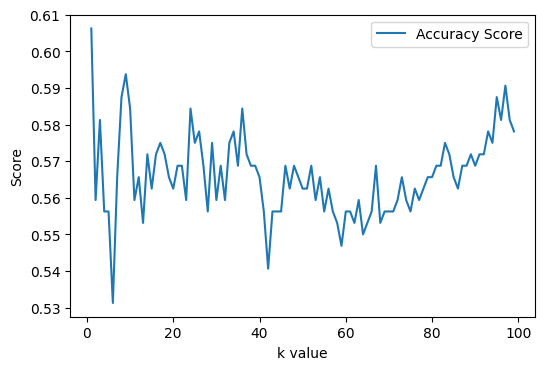

Accuracy score of the best k is: 0.60625


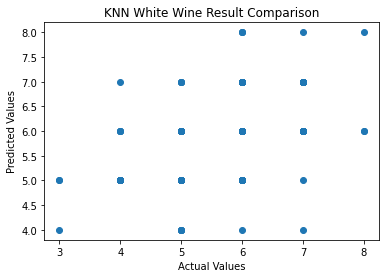

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        15
           5       0.71      0.66      0.68       138
           6       0.58      0.66      0.62       122
           7       0.54      0.54      0.54        39
           8       0.20      0.33      0.25         3

    accuracy                           0.61       320
   macro avg       0.34      0.37      0.35       320
weighted avg       0.59      0.61      0.60       320

------Colorful Confusion matrix------


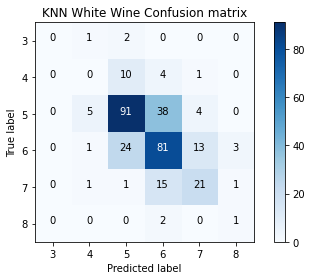

In [34]:
# KNN
KNN(red_Xtrain,red_Xtest, red_ytrain, red_ytest)

#### Navie Bayes

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        15
           5       0.67      0.68      0.67       138
           6       0.52      0.48      0.50       122
           7       0.33      0.41      0.36        39
           8       0.00      0.00      0.00         3

    accuracy                           0.53       320
   macro avg       0.25      0.26      0.26       320
weighted avg       0.52      0.53      0.53       320

------Colorful Confusion matrix------


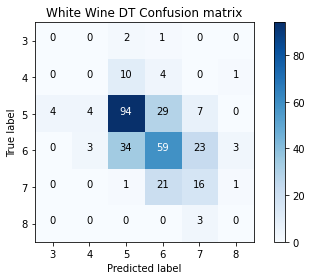

In [35]:
#Naive Bayes
NB(red_Xtrain,red_Xtest, red_ytrain, red_ytest)

#### Decision Tree

this is accuracy [0.55625, 0.525, 0.478125, 0.56875, 0.5375, 0.55625, 0.584375, 0.596875, 0.58125, 0.590625, 0.590625, 0.58125, 0.59375, 0.59375, 0.6, 0.584375, 0.609375, 0.61875, 0.609375, 0.609375, 0.603125, 0.60625, 0.584375, 0.59375, 0.5875, 0.61875, 0.59375, 0.60625, 0.63125, 0.603125, 0.603125, 0.615625, 0.6125, 0.615625, 0.596875, 0.6, 0.6, 0.609375, 0.6125, 0.621875, 0.609375, 0.6, 0.5875, 0.6, 0.603125, 0.584375, 0.634375, 0.6125, 0.6125, 0.6, 0.6, 0.60625, 0.6, 0.60625, 0.584375, 0.596875, 0.6, 0.6, 0.6, 0.615625, 0.5875, 0.5875, 0.6125, 0.609375, 0.59375, 0.59375, 0.596875, 0.596875, 0.60625, 0.603125, 0.6, 0.615625, 0.60625, 0.609375, 0.596875, 0.6, 0.6125, 0.60625, 0.59375, 0.60625, 0.5875, 0.596875, 0.6, 0.6, 0.6, 0.615625, 0.60625, 0.60625, 0.596875, 0.596875, 0.596875, 0.615625, 0.615625, 0.58125, 0.60625, 0.596875, 0.625, 0.60625, 0.615625]
0.634375
the best max depth is 47
Classification Report:
              precision    recall  f1-score   support

           3      

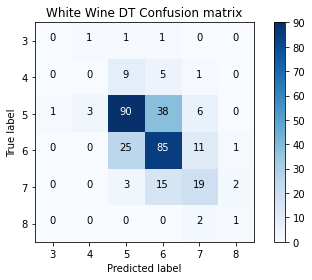

Feature: 0, Score: 0.09674
Feature: 1, Score: 0.14240
Feature: 2, Score: 0.08364
Feature: 3, Score: 0.08785
Feature: 4, Score: 0.11560
Feature: 5, Score: 0.10101
Feature: 6, Score: 0.07129
Feature: 7, Score: 0.14479
Feature: 8, Score: 0.15668


In [36]:
#Decision Tree, change print tree to True if you want to see the tree!
red_dt_imp = DT(red_Xtrain,red_Xtest, red_ytrain, red_ytest, print_tree=False)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        15
           5       0.74      0.77      0.75       138
           6       0.62      0.75      0.68       122
           7       0.71      0.44      0.54        39
           8       0.33      0.33      0.33         3

    accuracy                           0.68       320
   macro avg       0.40      0.38      0.38       320
weighted avg       0.64      0.68      0.65       320

------Colorful Confusion matrix------


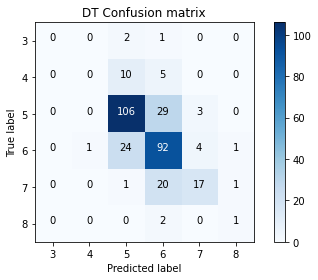

Feature: 0, Score: 0.09172
Feature: 1, Score: 0.12681
Feature: 2, Score: 0.07942
Feature: 3, Score: 0.09482
Feature: 4, Score: 0.12397
Feature: 5, Score: 0.10422
Feature: 6, Score: 0.08670
Feature: 7, Score: 0.12889
Feature: 8, Score: 0.16346


In [37]:
# Random Forest
red_rf_imp = RF(red_Xtrain,red_Xtest, red_ytrain, red_ytest)

## White Wine

### Split dataset

In [38]:
# split white wine data
white_X = white.drop(['Quality','Residual_Sugar'], axis = 1)
white_y = white.Quality
white_Xtrain,white_Xtest, white_ytrain, white_ytest = train_test_split(white_X,white_y, test_size=0.2, random_state=101)

### White Wine Regression

In [39]:
# Multiregression
# white_a = multi_regression(white_Xtrain,white_Xtest, white_ytrain, white_ytest)
# Ridge Regression
# white_b = ridge(white_Xtrain,white_Xtest, white_ytrain, white_ytest)
# Logistic Regression
# white_c = LR(white, white_Xtrain,white_Xtest, white_ytrain, white_ytest)

### White Wine Classification

#### KNN

the best K is: 1, and its score is 0.6408163265306123


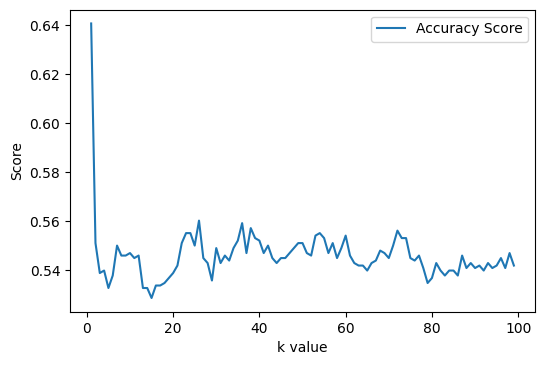

Accuracy score of the best k is: 0.6408163265306123


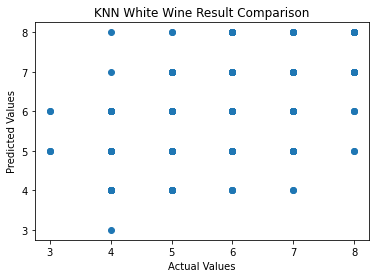

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.42      0.24      0.31        41
           5       0.64      0.64      0.64       306
           6       0.69      0.68      0.69       433
           7       0.60      0.66      0.63       158
           8       0.51      0.54      0.53        37

    accuracy                           0.64       980
   macro avg       0.47      0.46      0.46       980
weighted avg       0.64      0.64      0.64       980

------Colorful Confusion matrix------


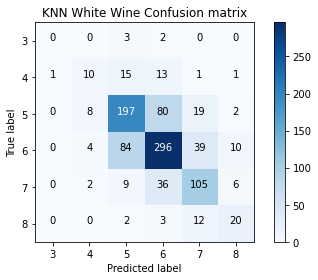

In [40]:
#KNN
KNN(white_Xtrain,white_Xtest, white_ytrain, white_ytest)

#### Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           3       0.08      0.20      0.11         5
           4       0.21      0.17      0.19        41
           5       0.54      0.57      0.56       306
           6       0.55      0.36      0.44       433
           7       0.34      0.68      0.46       158
           8       0.17      0.03      0.05        37

    accuracy                           0.46       980
   macro avg       0.31      0.34      0.30       980
weighted avg       0.48      0.46      0.45       980

------Colorful Confusion matrix------


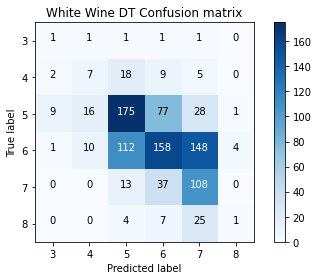

In [41]:
#Naive Bayes
NB(white_Xtrain,white_Xtest, white_ytrain, white_ytest)

#### Decision Tree

this is accuracy [0.4418367346938776, 0.5316326530612245, 0.5214285714285715, 0.5295918367346939, 0.5316326530612245, 0.5285714285714286, 0.5346938775510204, 0.55, 0.563265306122449, 0.55, 0.5448979591836735, 0.5448979591836735, 0.5714285714285714, 0.5530612244897959, 0.576530612244898, 0.5806122448979592, 0.5806122448979592, 0.576530612244898, 0.5816326530612245, 0.5816326530612245, 0.5816326530612245, 0.5877551020408164, 0.5775510204081633, 0.5908163265306122, 0.5795918367346938, 0.576530612244898, 0.5938775510204082, 0.5918367346938775, 0.5795918367346938, 0.5928571428571429, 0.5959183673469388, 0.5846938775510204, 0.5948979591836735, 0.5846938775510204, 0.5816326530612245, 0.6, 0.5785714285714286, 0.6040816326530613, 0.5969387755102041, 0.5897959183673469, 0.5867346938775511, 0.5908163265306122, 0.5867346938775511, 0.5795918367346938, 0.5918367346938775, 0.5867346938775511, 0.5867346938775511, 0.5887755102040816, 0.5877551020408164, 0.5806122448979592, 0.5928571428571429, 0.5857142

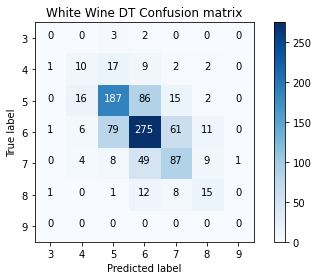

Feature: 0, Score: 0.07939
Feature: 1, Score: 0.10091
Feature: 2, Score: 0.08164
Feature: 3, Score: 0.09010
Feature: 4, Score: 0.09960
Feature: 5, Score: 0.09346
Feature: 6, Score: 0.09988
Feature: 7, Score: 0.10639
Feature: 8, Score: 0.09210
Feature: 9, Score: 0.15651


In [42]:
#Decision Tree, change print tree to True if you want to see the tree!
white_dt_imp = DT(white_Xtrain,white_Xtest, white_ytrain, white_ytest, print_tree=False)

#### Random Forest

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.70      0.17      0.27        41
           5       0.71      0.70      0.70       306
           6       0.66      0.78      0.72       433
           7       0.68      0.58      0.63       158
           8       0.83      0.41      0.55        37

    accuracy                           0.68       980
   macro avg       0.60      0.44      0.48       980
weighted avg       0.68      0.68      0.67       980

------Colorful Confusion matrix------


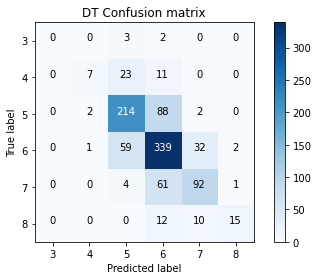

Feature: 0, Score: 0.08384
Feature: 1, Score: 0.10524
Feature: 2, Score: 0.08997
Feature: 3, Score: 0.09029
Feature: 4, Score: 0.10437
Feature: 5, Score: 0.10059
Feature: 6, Score: 0.11536
Feature: 7, Score: 0.09590
Feature: 8, Score: 0.08782
Feature: 9, Score: 0.12662


In [43]:
# Random Forest
white_rf_imp = RF(white_Xtrain,white_Xtest, white_ytrain, white_ytest)

## Feature Importance

### Red Wine

#### Decision Tree

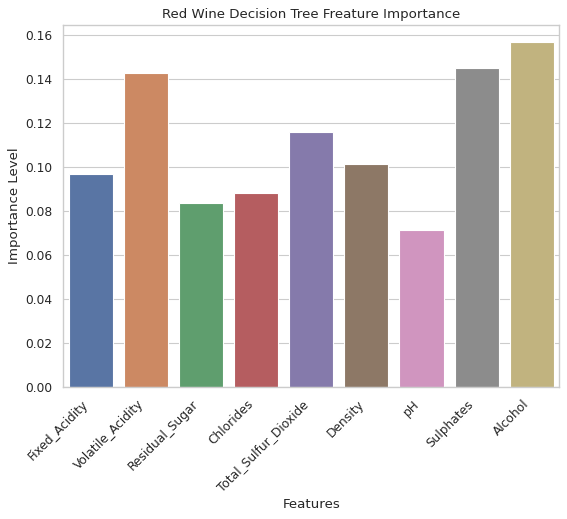

In [44]:
# Red Decision Tree
barplot(red_X.columns, red_dt_imp, 45, 'Red Wine Decision Tree Freature Importance')

#### Random Forest

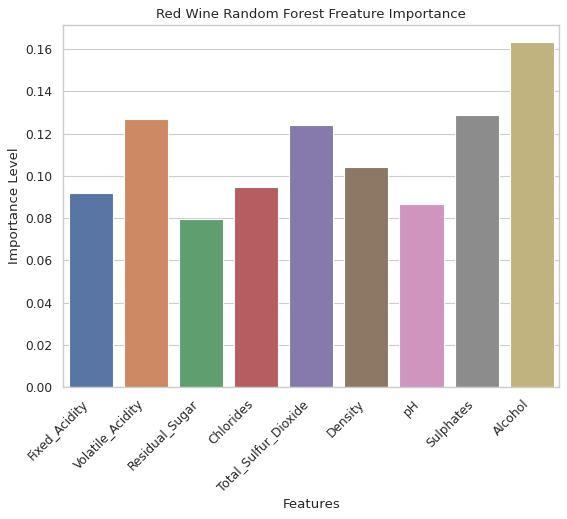

In [45]:
# Red Random Forest
barplot(red_X.columns, red_rf_imp, 45, 'Red Wine Random Forest Freature Importance')

#### Line Charts

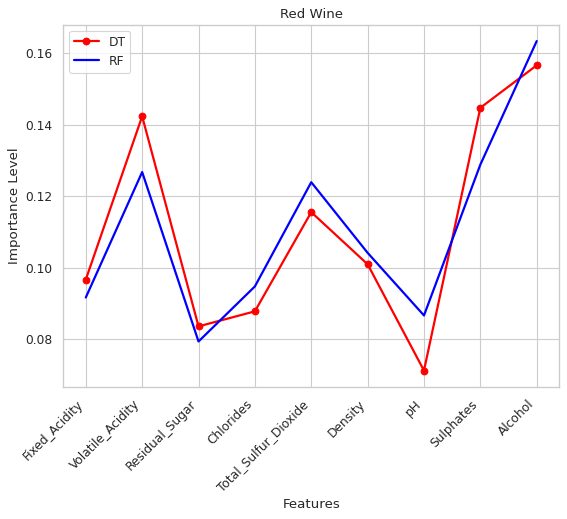

In [46]:
# Red Wine Line Charts
plt.figure(figsize=(8, 6), dpi=80)
plt.plot( red_X.columns, red_dt_imp, marker='o', color='red', linewidth=2)
plt.plot( red_X.columns, red_rf_imp, marker='', color='blue', linewidth=2)
plt.xticks(rotation = 45,horizontalalignment="right") 
plt.title('Red Wine')
plt.xlabel('Features')
plt.ylabel('Importance Level')
plt.legend(['DT', 'RF'])
plt.show()

### White Wine

#### Decision Tree

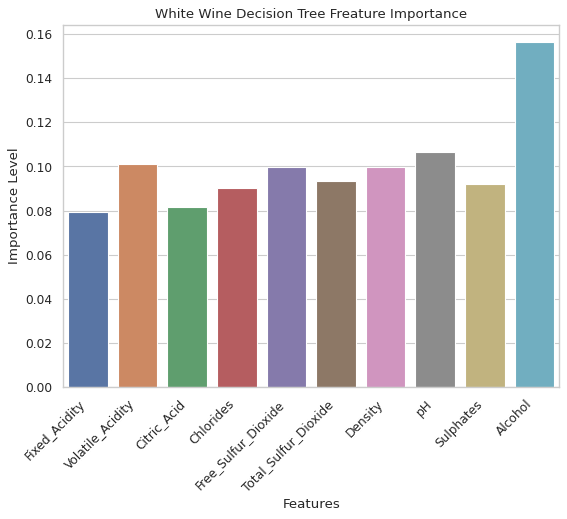

In [47]:
barplot(white_X.columns, white_dt_imp,45, 'White Wine Decision Tree Freature Importance')

#### Random Forest

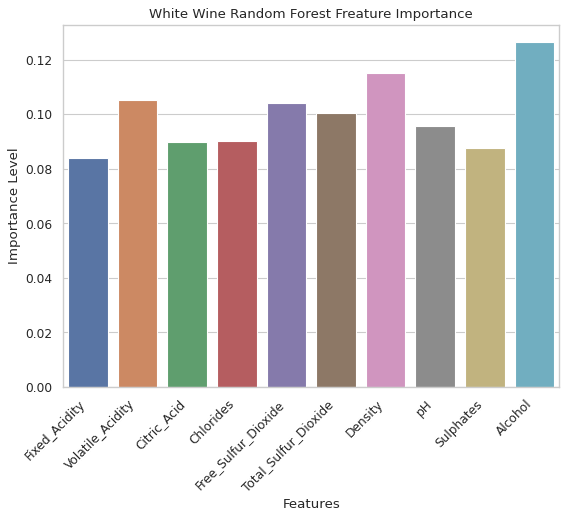

In [48]:
barplot(white_X.columns, white_rf_imp,45, 'White Wine Random Forest Freature Importance')

#### Line Charts

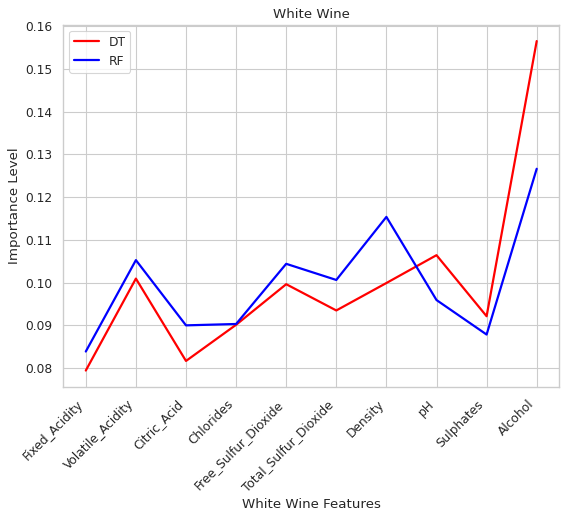

In [49]:
# White Wine Line Charts
plt.figure(figsize=(8, 6), dpi=80)
plt.plot( white_X.columns, white_dt_imp, marker='', color='red', linewidth=2)
plt.plot( white_X.columns, white_rf_imp, marker='', color='blue', linewidth=2)
plt.xticks(rotation = 45,horizontalalignment="right")
plt.title('White Wine') 
plt.xlabel('White Wine Features')
plt.ylabel('Importance Level')
plt.legend(['DT', 'RF'])
plt.show()